# IT-Talents / Materna Code Competition 01/2020
https://www.it-talents.de/foerderung/code-competition/code-competition-01-2020

## Dataset description
6 years of race records from a race game<br/>
Columns:
- `ID`: race id
- `race_created`: timestamp of when the race was created
- `race_drive`: timestamp of when the race was driven
- `track_id`: the track id where the race took place
- `challenger`: the challenger player id
- `opponent`: the opponent player id
- `money`: the stake each player has to pay (in euro)
- `fuel_consumption`: the fuel consumedduring the race (in liters)
- `winner`: the winner of the race
- `status`: the race status
- `forecast`: the weather forcast for the race 
- `weather`: the actual weather during the race

## 1. Dataset Profiling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

df = pd.read_csv("data/races.csv", sep=";")
profile = ProfileReport(df, minimal=True)
profile

From the profile report we get a quick overview of the dataset. 
The warnings tell us that we can parse the `race_created` column as datetime and that columns `winner` and `weather` have lots of zeros / missing data.
In the following we take care of the data cleaning and the proper parsing of the forecast string and other columns.

## 2. Data Cleaning & Feature Extraction

In [2]:
from preprocessing import DataPreprocessor
df, weather_conditions = DataPreprocessor().process_data("data/races.csv", sep=";")

In [3]:
df.head(3)

,id,race_created,race_driven,track_id,challenger,opponent,money,fuel_consumption,winner,status,...,month,dayofweek,hour,forecast_argmax,forecast_weather,forecast_correct,global_accuracy,rolling_1000_accuracy,rolling_10000_accuracy,player_tuple
0,1,06.03.2012,2012-06-03 00:00:00,12,5,2,30,0.63,5,finished,...,6,6,0,1,rainy,True,0.653535,NaN,NaN,"(2, 5)"
1,2,06.03.2012,2012-06-03 00:03:00,12,5,4,30,0.63,4,finished,...,6,6,0,0,sunny,True,0.653535,NaN,NaN,"(4, 5)"
2,4,06.03.2012,2012-06-03 00:06:00,12,5,4,30,0.63,5,finished,...,6,6,0,1,rainy,False,0.653535,NaN,NaN,"(4, 5)"


In [4]:
df.shape

(109099, 28)

The `DataPreprocessor` takes care of the csv loading, data parsing and data cleaning. It also adds some time-dependent features for later use. <br/>
Added features:
- `forecast_sunny`: the sunny forecast probability
- `forecast_rainy`: the rainy forecast probability
- `forecast_thundery`: the thundery forecast probability
- `forecast_snowy`: the snowy forecast probability
- `forecast_array`: array containing probabilities for all weather conditions
- `forecast_argmax`: the index of the forecast array with highest probability
- `forecast_weather`: weather string of the forecast
- `forecast_correct`: whether the forecast was correct or not
- `weather_id`: weather mapped to id
- `hour`: the hour a race was driven
- `dayofweek`: the day of the week a race was driven
- `global_accuracy`: the global accuracy of the forecast (same for all rows)
- `rolling_1000_accuracy`: rolling accuracy
- `rolling_10000_accuracy`: rolling accuracy
- `player_tuple`: tuple containing the sorted involved player ids


We are now ready to start the analysis and hopefully gain some interesting insights.

## 3. Race Activity Analysis
Let's first take a look at how the monthly number of races developed over time:

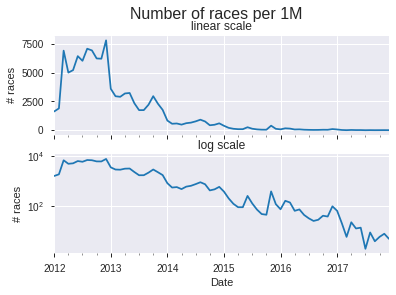

In [5]:
from race_activity import RaceActivity
RaceActivity().plot_time_aggregated_n_races(df, freq="1M")

[High resolution screenshot](plots/number_of_races_over_time_1M.png)

We can see that the highest activity took place in the first year after launch, with a peak of almost 8000 races per month. From there on, the popularity decreased gradually over time. After the third year we see almost no more change on the linear scale plot, however the log scale reveals that the downward trend is still ongoing. <br/><br/>
The `DataPreprocessor` extracted `hour`, `month` and `dayofweek` from the `race_driven` column. We can use them to aggregate the races and see if a pattern reveals:

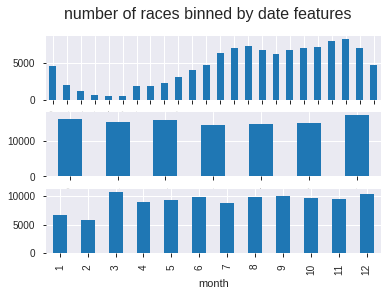

In [6]:
RaceActivity().plot_aggregated_by_features(df, features=["hour", "dayofweek", "month"])

[High resolution screenshot](plots/number_of_races_grouped_by_time.png)

The aggregation by hour shows that on average, the race activity increases steadily in the morning hours until it peaks at around 14 o'clock, followed by a short siesta. The global peak occurs at 21 o'clock, which seems reasonable.<br/>
On the second plot we see slightly increased activity on sundays and the monthly aggregation shows lower activity during January and February compared to the other months.

## 4. Player Analysis
First we need to extract the players from the races dataset:

In [7]:
from player_analysis import PlayerAnalysis
pdf, track_ids = PlayerAnalysis().get_players_df(df)

In [8]:
pdf.head(3)

,player_id,n_wins,n_challenger,n_opponent,money_won,track_diversity,track_probabilities,money_lost,net_profit,n_races,n_losses,win_ratio,race_balance,avg_profit_per_race,first_race,last_race,lifespan
player_id,,,,,,,,,,,,,,,,,
1,1,24,21,70,750,0.608984,"[0.4725274725274725, 0.01098901098901099, 0.05...",3010,-2260,91,67,0.263736,-43,-24.835165,2012-01-08 16:01:00,2016-12-11 08:49:00,1798 days 16:48:00
2,2,0,0,1,0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",30,-30,1,1,0.000000,-1,-30.000000,2012-06-03 00:00:00,2012-06-03 00:00:00,0 days 00:00:00
3,3,1133,1251,235,255297,0.435727,"[0.07133243606998654, 0.0, 0.21534320323014805...",164025,91272,1486,353,0.762450,780,61.421265,2012-01-04 00:30:00,2013-05-30 21:39:00,512 days 21:09:00


In [9]:
pdf.shape

(5749, 17)

The following features were calculated for each player:
- `n_wins`: number of wins
- `n_losses`: number of losses
- `win_ratio`: ratio of won and lost races
- `n_challenger`: number of races where the player was the challenger
- `n_opponent`: number of races where the player was the opponent
- `track_probabilities`: array of track probabilities based on historical races
- `track_diversity`: track diversity score calculated as normalized inverse track probabilities standard deviation
- `money_won`: sum of won race bounties
- `money_lost`: sum of lost race bounties
- `net_profit`: the actual profit or loss a player made
- `n_races`: number of races a player made
- `race_balance`: difference of n_wins and n_losses
- `avg_profit_per_race`: the average profit or loss a player made per race
- `first_race`: date of a player's first race
- `last_race`: date of a player's last race
- `lifespan`: the timespan the player was active

We can find many interesting players with this features but let's first use the `first_race` and `last_race` dates in order to visualize the player in- and outflux. We group the dates into monthly bins so we get an aggregated view:

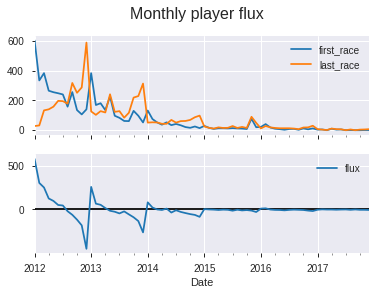

In [10]:
PlayerAnalysis().plot_flux(pdf, freq="1M")

[High resolution screenshot](plots/monthly_player_flux.png)

The top plot shows the number of first races vs the number of last races per month. Not surprisingly, we see a peak in first matches at the beginning of the dataset. More interesting is the peak of last matches at the end of 2012. Maybe the game operators had technical issues during that time period or many players made a new account because of some event. Soon after the outflux peak, we see a peak in first races which may be the result of a marketing campaign. The pattern repeats itself with a yearly cycle, however the amplitude gets smaller and smaller.<br/>
The bottom plot show the difference between the player influx and outflux. The pattern of large outflux followed by influx and the decrease of amplitude becomes even clearer.<br/>
In the end, the game was not able to withstand the steady player outflux pressure.

Enough game development over time, let's find some extreme individual players and visualize their player profile:

#### Player with most races:

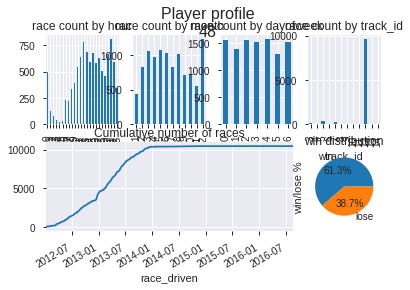

In [11]:
PlayerAnalysis().plot_player_profile(df, pdf, pdf.sort_values("n_races").iloc[-1].player_id)

[High resolution screenshot](plots/player_profile_most_races.png)

Wow, player 48 played more than 10000 races in two years! That's almost 14 races per day.

#### Player with the highest net profit:

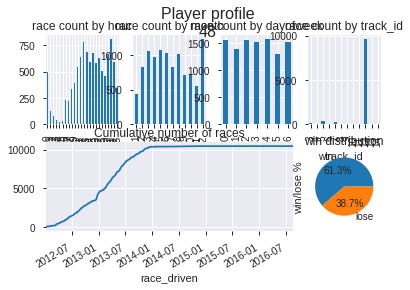

In [12]:
PlayerAnalysis().plot_player_profile(df, pdf, pdf.sort_values("net_profit").iloc[-1].player_id)

[High resolution screenshot](plots/player_profile_most_races.png)

Again player_id 48, makes kind of sense. Let's look at the second highest then:

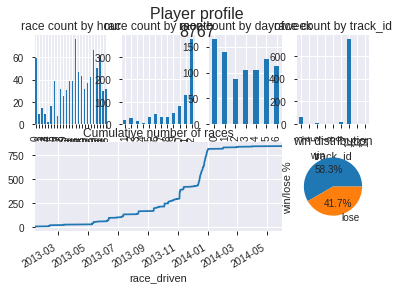

In [13]:
PlayerAnalysis().plot_player_profile(df, pdf, pdf.sort_values("net_profit").iloc[-2].player_id)

[High resolution screenshot](plots/player_profile_second_highest_net_profit.png)

We see that both players almost exclusively played track 12. The race accumulation curve for player 48 looks linear whereas the one of player 8767 looks more exponential. Both players stopped playing the game actively at around the same time (January 2014). Interestingly, a win rate of around 60% is sufficient to become the top profit maker in this game.<br/>
It is also worth to mention the big difference between the first and second place:

In [14]:
pdf.sort_values("net_profit").tail(2)[["net_profit"]]

,net_profit
player_id,
8767,3148238
48,15005319


Reason enough to quickly draw a boxplot of all net_profits:

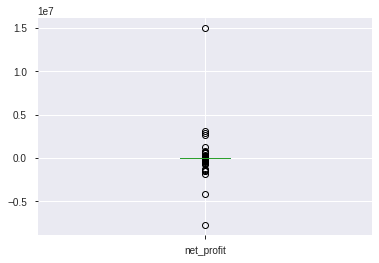

In [15]:
pdf.net_profit.plot.box()

The boxplot is dominated by outliers and the interquartile range is comparatively small, so let's use pandas describe():

In [16]:
pdf.net_profit.describe().round(2)

count        5749.00
mean            0.00
std        245248.97
min      -7764856.00
25%          -482.00
50%          -110.00
75%           -30.00
max      15005319.00
Name: net_profit, dtype: float64

The quantiles confirm the hypothesis that the "normal" player loses in money betting games.<br/>
In fact, only 17.5% of all players are in profit:

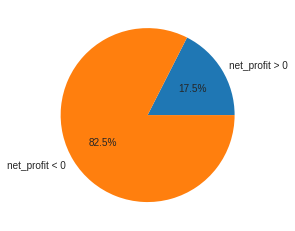

In [17]:
in_profit_ratio = pdf[pdf.net_profit>0].shape[0] / pdf.shape[0]
_ = plt.pie([in_profit_ratio, 1-in_profit_ratio], labels=["net_profit > 0", "net_profit < 0"], autopct="%1.1f%%")

#### Player with the highest track diversity

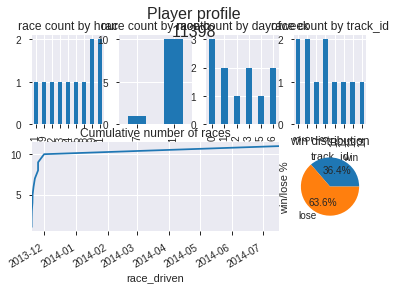

In [18]:
PlayerAnalysis().plot_player_profile(df, pdf, pdf.sort_values("track_diversity").iloc[-1].player_id)

[High resolution screenshot](plots/player_profile_highest_track_diversity.png)

This player has only 11 races, but he tried every track at least once before giving up the game. The win rate of only 36.4% might suggest that he matched up against too strong opponents. Maybe he would have played more often with a better matchmaking system.

#### Let's see how the win rates look for all players:

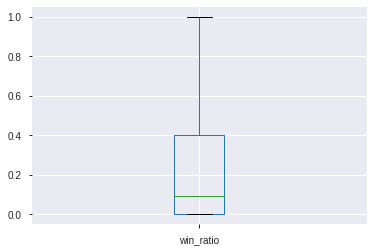

In [19]:
_ = pdf.win_ratio.plot.box()

The plot suggests that the majority of players don't even win half of their races, which is not very satisfactory from a player's perspective.

#### And the number of races of all players:

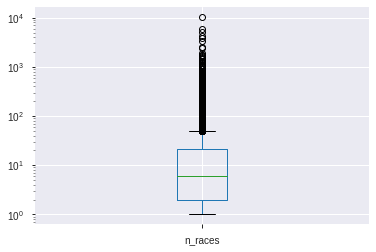

In [20]:
ax = pdf.n_races.plot.box()
ax.set_yscale("log")

In [21]:
pdf.n_races.describe().round(2)

count     5749.00
mean        37.95
std        223.93
min          1.00
25%          2.00
50%          6.00
75%         21.00
max      10461.00
Name: n_races, dtype: float64

The average player stopped playing the game after 6 races.

#### Players grouped by track preference

A matchmaking system could consider player similarities w.r.t. various variables in order to maximize the gaming experience for all users. Here we try to group players with similar track preferences. We use the previously calculated `track_probabilities` for this purpose.

In [22]:
X = np.stack(pdf.track_probabilities.values)

In [23]:
X.shape

(5749, 12)

Our feature vector has 12 dimensions, so we use PCA to reduce them to two in order to visually estimate the number of clusters. We use the `track_diversity` as color.

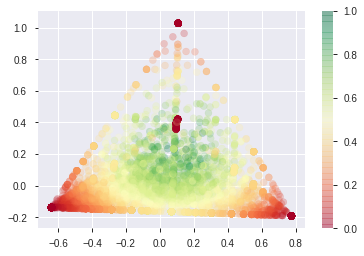

In [24]:
PlayerAnalysis().plot_pca(X, c=pdf.track_diversity.values)

[High resolution screenshot](plots/track_preference_pca.png)

Looks pretty cool! We found the illuminati triangle of track preference. The coloring suggests that it is rather a pyramid in three dimensions, so we set the number of clusters we are looking for to 5. One for each corner of the imaginary pyramid and one for the inner part, if that makes sense. We use KMeans as clustering algorithm:

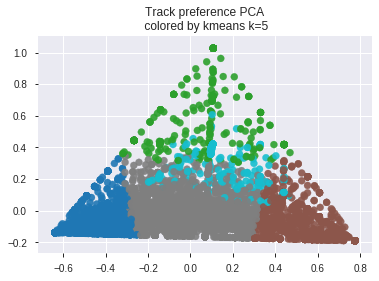

In [25]:
cluster_prediction_k5 = PlayerAnalysis().plot_kmeans(X, k=5)

[High resolution screenshot](plots/track_preference_kmeans_k5.png)

Not excatly what we were looking for but not bad at all. The corner in the imaginary third dimension (teal) is well separated. We can also look at the clustering with k=3:

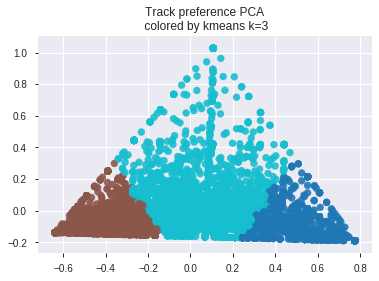

In [26]:
cluster_prediction_k3 = PlayerAnalysis().plot_kmeans(X, k=3)

[High resolution screenshot](plots/track_preference_kmeans_k3.png)

Looks like a reasonable clustering as well but I prefer k=5 for now.

In [27]:
pdf["track_preference_cluster"] = cluster_prediction_k5

The track preferences for each cluster look as follows:

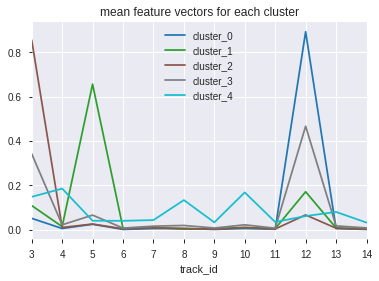

In [28]:
PlayerAnalysis().plot_cluster_means(pdf, "track_preference_cluster", track_ids)

[High resolution screenshot](plots/track_preference_per_cluster_k5.png)

With the plot we can interpret the clusters as follows:
- Cluster 0 (blue): players of this cluster almost exclusively play track 12. On rare events they are up for a race on track 3.
- Cluster 1 (green): player of this cluster mostly play track 5 but sometimes also track 12 and 3.
- Cluster 2 (brown): Absolute track 3 fans. In rare cases they play a race on track 12.
- Cluster 3 (grey): Prefer track 3 and 12, sometimes 5. Seems like a compromise between Cluster 0 and 2.
- Cluster 5 (teal): Allround players. Not track 12 hype affected.

Fair enought, let's also take a look at the k=3 case:

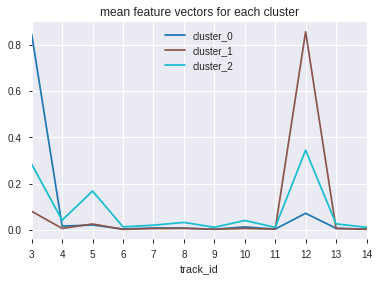

In [29]:
pdf["track_preference_cluster"] = cluster_prediction_k3
PlayerAnalysis().plot_cluster_means(pdf, "track_preference_cluster", track_ids)

[High resolution screenshot](plots/track_preference_per_cluster_k3.png)

Interpretation:
- Cluster 0 (blue): track 3 lovers.
- Cluster 1 (brown): track 12 lovers.
- Cluster 2 (teal): Allrounders with preference for track 3, 5 and 12

We could do the same analysis for example with the hour profile and find groups of players with similar temporal patterns. This could be useful for tournament matchup planning. However, time is running short.

## 5. Pair Analysis
Every race involves two players, so it seems natural to look at the data from a pair perspective. We use the previously calculated `player_tuple` here. It allows us to efficiently calculate pair statistics.

In [30]:
from pair_analysis import PairAnalysis
pair_counts, ppdf = PairAnalysis().calculate_pair_statistics(df)

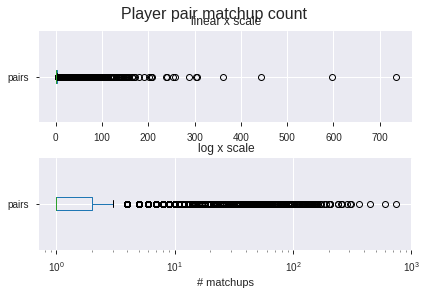

In [31]:
PairAnalysis().plot_pair_counts(pair_counts)

[High resolution screenshot](plots/pair_analysis_boxplot.png)

The boxplot tells us that the average player plays solo and has no regular racing mate. 99% of all player pair matchups occur less than three times. However there are many player pairs above the upper whisker. These are the player pairs which matchup frequently against each other. We see high density in the 20 - 110 range.<br/>
Let's plot the pair profile for the player pair with most matchups:

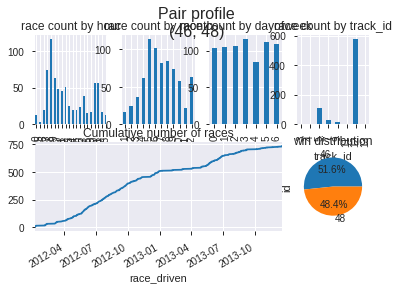

In [32]:
PairAnalysis().plot_pair_profile(df, pair=pair_counts.sort_values().index.values[-1])

[High resolution screenshot](plots/pair_analysis_top_pair.png)

Looks like a well balanced racing friendship. They played regularly against each other for two years, especially in the morning hours. We also see a period of low racing activity in the first quarter of 2013.

We can use the pair matchup statistics to add further features to the players dataframe. For example the number of unique matchups a player had. Normalized by the total number of players, we get the percentage of all players a player played against.

In [33]:
ppdf.tail(3)

,unique_matchups,unique_matchups_all_player_pct
player_id,,
2866,589,0.102453
32,748,0.130110
48,1088,0.189250


The famous player 48 raced against 18.9% of all players. Not bad.

In [34]:
pdf = ppdf.join(pdf)

We can now dividide the number of unique matchups by the number of races of each player, which should give us an indicator of "soloness" of a player. We take the inverse of that and call it `race_friendship_rating`

In [35]:
pdf["race_friendship_rating"] = 1 - (pdf.unique_matchups/pdf.n_races)
pdf.sort_values("race_friendship_rating").tail(5)

,unique_matchups,unique_matchups_all_player_pct,player_id,n_wins,n_challenger,n_opponent,money_won,track_diversity,track_probabilities,money_lost,...,n_races,n_losses,win_ratio,race_balance,avg_profit_per_race,first_race,last_race,lifespan,track_preference_cluster,race_friendship_rating
player_id,,,,,,,,,,,,,,,,,,,,,
6822,1,0.000174,6822,0,41,1,0,0.191848,"[0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0,...",47730,...,42,42,0.0,-42,-1136.428571,2012-01-12 10:00:00,2013-11-01 07:11:00,658 days 21:11:00,1,0.976190
11189,1,0.000174,11189,0,36,9,0,0.063251,"[0.9555555555555556, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3750,...,45,45,0.0,-45,-83.333333,2013-10-27 10:37:00,2014-12-07 08:55:00,405 days 22:18:00,0,0.977778
6022,1,0.000174,6022,0,61,0,0,0.000000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22940,...,61,61,0.0,-61,-376.065574,2012-01-11 20:21:00,2012-12-11 17:45:00,334 days 21:24:00,0,0.983607
7910,1,0.000174,7910,0,73,0,0,0.000000,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",79607,...,73,73,0.0,-73,-1090.506849,2013-01-02 19:20:00,2013-12-02 22:33:00,334 days 03:13:00,2,0.986301
4857,1,0.000174,4857,0,88,0,0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59156,...,88,88,0.0,-88,-672.227273,2012-02-09 20:40:00,2013-12-01 19:22:00,660 days 22:42:00,1,0.988636


The player with the highest `race_friendship_rating` played 88 times against his mate and never played solo. We see that this is not uncommon. Let's plot the pair profile for them:

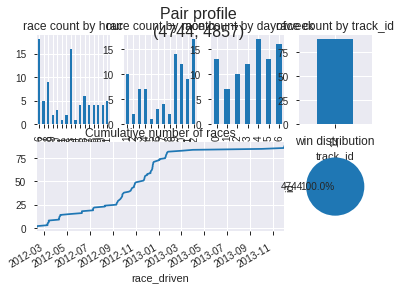

In [36]:
pair = df[(df.challenger == 4857) | (df.opponent == 4857)].player_tuple.iloc[-1]
PairAnalysis().plot_pair_profile(df, pair=pair)

[High resolution screenshot](plots/pair_analysis_friendship.png)

Surprisingly we most likely did not discover a good racing friendship but found cases of potential race statistic manipulation using fake accounts. Not sure but the win ratio is very suspicious.

## 6. Forecast Analysis
`forecast` is an interesting column in the dataset because it contains the probabilities for each weather condition as values from 0 to 100. In order to get a definitive weather prediction, we can pick the condition with the highest probability. We already did this in the preprocessing step and stored the weather index in `forecast_argmax` and the forecast weather name in `forecast_weather`. So let's start analyzing:

#### Can we trust the weather forecast?
To answer this question we can use scikit-learn's classification report:

In [37]:
from sklearn.metrics import classification_report
print(classification_report(df.weather.values, df.forecast_weather))

              precision    recall  f1-score   support

       rainy       0.60      0.56      0.58     27292
       snowy       0.54      0.33      0.41     13501
       sunny       0.71      0.86      0.77     54708
    thundery       0.53      0.34      0.42     13598

    accuracy                           0.65    109099
   macro avg       0.59      0.52      0.55    109099
weighted avg       0.64      0.65      0.64    109099



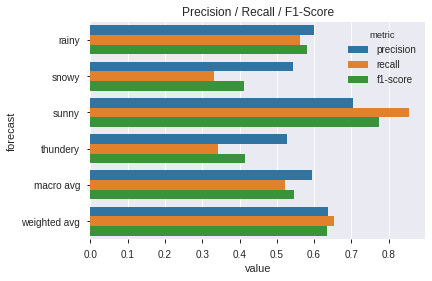

In [38]:
from weather_forecast import WeatherForecastAnalysis
wfa = WeatherForecastAnalysis(weather_conditions)
wfa.plot_precision_recall(df)

[High resolution screenshot](plots/forecast_precision_recall.png)

The forecast has an accuracy of 65%. The precision and recall values reveal a significant difference among the classes. For sunny, a precision of 0.71 means that 71% of the sunny predictions were correct. Recall 0.86 means that the forecast was able to predict sunny in 86% of all sunny days. The f1-score combines both metrics.<br/>
We can see that the forecast is most reliable for the sunny weather condition. Rain and snow seem to be harder to predict. The low recall indicates that those weather events are mostly unpredictable, however when the forecast predicts such particular class, it's with a precision of 0.54 and 0.53 better than a coin flip. So in general we can say that the forecast is better than guessing.

#### Which classes get confused most often?
In order to gain insight into which classes get confused with each other, we can look at the confusion matrix:


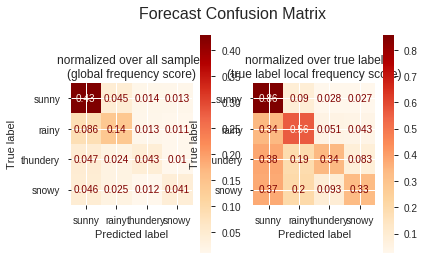

In [39]:
wfa.plot_forecast_confusion_matrix(df)

[High resolution screenshot](plots/forecast_confusion_matrix.png)

The true weather is on the y-axis, the forecast on the x-axis. In the left plot, we have normalized the number of occurrences by the number of all forecast events, whereas the plot on the right shows the values normalized by the number of occurrences of the actual weather condition (rows). We notice that the diagonal corresponds to the recall values. The confusion matrix also clearly shows the forecast ambiguity for thundery and snowy.

#### Did the forecast accuracy degrade over time?<br/> Is the accuracy higher/lower on certain tracks? <br/>Do seasons influence forecast accuracy?


To analyze the forecast accuracy over time, we use rolling windows for the accuracy calculation and plot the result:

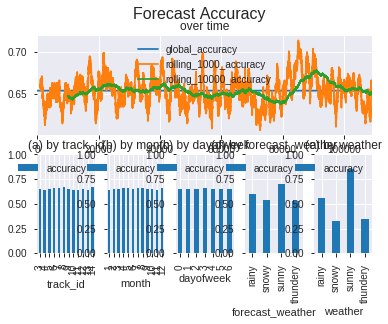

In [40]:
wfa.plot_conditional_accuracy_analysis(df)

[High resolution screenshot](plots/forecast_accuracy_analysis.png)

The rolling accuracies oscillate around the global accuracy which is the expected behaviour. We don't see an accuracy degradation. Further we grouped the races by temporal features and calculated the accuracy of each group. However there is no significant pattern visible, it looks like temporal factors do not influence the forecast accuracy. The same is true for the track. 

#### Does the weather forecast distribution differ among tracks and does it reflect the true weather conditions? 

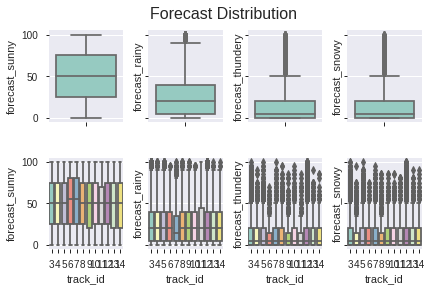

In [41]:
wfa.plot_forecast_boxplots_by_trackid(df)

[High resolution screenshot](plots/forecast_distribution.png)

The top plot shows boxplots for each column in the forecast array of all races.<br/>
In the bottom plot we further grouped the races by track_id. We see only minor differences in the inter-quartile range and the top whisker across the tracks, which could be the result of a too small sample size.<br/> Let's draw the true weather distribution per track to confirm our hypothesis that the weather and the weather forecast do not depend on the track:

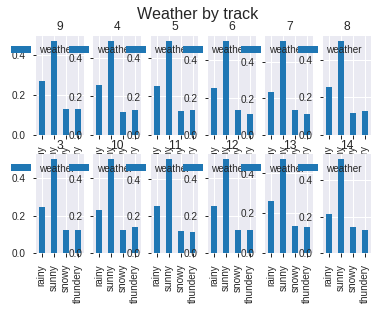

In [42]:
wfa.plot_weather_distribution_by_trackid(df)

[High resolution screenshot](plots/weather_by_track.png)

As suspected, the weather distribution looks the same for all tracks. So there is no track famous for its rainy weather.

## 7. Winner prediction
In order to predict the outcome of a race, we could condition the dataset on the involved player ids and calculate the win distribution between the players. Of course, this only works when we have a large enough race history between the players.


In [43]:
from race_prediction import RacePrediction
RacePrediction().predict_winner(df, player_id1=46, player_id2=48)

46

In order to properly test the performance of our simple predictor, we need to split the dataset into train and test splits and calculate the win distribution only on the train set. We chose a small test size so that the evaluation is quick and we hopefully don't get so many matchups where we have no historical data.

In [44]:
    test_split = 0.1
    test_split_idx = int(df.shape[0]*test_split)
    train_df = df.iloc[:-test_split_idx]
    test_df = df.iloc[-test_split_idx:].copy()
    evaluation_result = RacePrediction().evaluate_predictions(train_df, test_df)
    evaluation_result

{'accuracy': 0.6428571428571429, 'races_predicted': 0.08726739389494913}

Over 64% test accuracy. Not bad considering the simplicity of the "model". However we only had race history for 8.7% of the matchups in the test set.<br/>
A further improvement could be to consider the track id where the race is about to be played, derive a "track skill score" for each player and incorporate this score in the prediction process.

## 8. Final remarks
Thanks to the organizers of the competition, it was fun to work with the dataset!
